Bring in the RLBench BC data from the saved hdf5 data files for each task. The task files were created with the instructRL/data/collect_data.py script. The task files include an array of data samples.  Each sample is a dict that includes the following keys:

* image - data for 4 camera positions: front_rgb, left_shoulder_rgb, right_shoulder_rgb, wrist_rgb
* instruct - the text instruction
* action - the action vector: [p;q;g] where for RLBench the gripper state is a single scalar open or closed [1,0]

In [1]:
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from getdata import RLBenchDataset
import torch
import time
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import pprint as pp

In [2]:
import torch
from torch import nn, Tensor
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        # even indices are sine, odd indices are cosine
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[ batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [3]:


class ActionDecoderModel(nn.Module):

    def __init__(self, action_dim: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5, action_seq_len: int = 5,
                 mem_seq_len: int = 5, test_mode=False):
        super().__init__()
        self.pos_encoder = PositionalEncoding(d_model, dropout=0, max_len=action_seq_len).cuda()
        decoder_layer = TransformerDecoderLayer(d_model, nhead, d_hid, dropout, batch_first=True).cuda()
        self.transformer_decoder = TransformerDecoder(decoder_layer, nlayers).cuda()
        self.d_model = d_model
        self.linear_action_in = nn.Linear(action_dim, d_model).cuda()
        # The output of the transformer decoder is a sequence of length action_seq_len-1 because it doesn't have sos token
        self.linear_action_out = nn.Linear(d_model, action_dim).cuda()
        self.test_mode = test_mode
        

    def forward(self, actions: Tensor, memory: Tensor) -> Tensor:
        """
        actions: [batch_size, action_seq_len, action_dim]
        memory: [batch_size, mem_seq_len, d_model]
        """
        actions = self.linear_action_in(actions)
        actions = self.pos_encoder(actions)

        if self.test_mode:
            # If mixing tasks, then we will need padding masks in the batch
            output = self.transformer_decoder(
                tgt=actions, 
                memory=memory
                )
            
        else:
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(actions.size(1)).cuda()
            # causal memory mask to prevent attending to future actions of size mem_seq_len x action_seq_len upper triangular part should be True (is masked)
            mem_mask = torch.triu(torch.ones(actions.size(1), memory.size(1)), diagonal=1).bool().cuda()
            
            # If mixing tasks, then we will need padding masks in the batch
            output = self.transformer_decoder(
                tgt=actions, 
                memory=memory, 
                tgt_mask=tgt_mask,
                )


        output = self.linear_action_out(output)
        return output

In [4]:



# Read in the RLBench training data.  The RLBenchDataset class is a subclass of the PyTorch Dataset class.
batch_size = 5
task_name = "reach_target"
# Load the training dataset and create a PyTorch DataLoader object.
train_dataset = RLBenchDataset(
    update=None,
    dataset_name=task_name,
    start_offset_ratio=None,
    split="train",
)

train_loader = torch.utils.data.DataLoader(    
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2)

# Load the validation dataset and create a PyTorch DataLoader object.
val_dataset = RLBenchDataset(
    update=None,
    dataset_name=task_name,
    start_offset_ratio=None,
    split="val",
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2)

In [5]:
print(f"Training dataset batch info:")
for i, (data, target) in enumerate(train_loader):
    print("action:", data['action'].shape)
    print("encoder_emb:", data['encoder_emb'].shape)
    print("target:", target.shape)
    break
print("num batches: " + str(len(train_loader)))

print(f"Val dataset batch info:")
for i, (data, target) in enumerate(val_loader):
    print("action:", data['action'].shape)
    print("encoder_emb:", data['encoder_emb'].shape)
    print("target:", target.shape)
    break
print("num batches: " + str(len(val_loader)))
print(data['action'].shape[1])


Training dataset batch info:
action: torch.Size([100, 3, 8])
encoder_emb: torch.Size([100, 395, 768])
target: torch.Size([100, 2, 8])
num batches: 12
Val dataset batch info:
action: torch.Size([100, 3, 8])
encoder_emb: torch.Size([100, 395, 768])
target: torch.Size([100, 2, 8])
num batches: 5
3


In [6]:

# max number of tokens in encoder embeddings for the training tasks in a batch. Can be constant if all same task, otherwise needs to be computed. Also determines whether a padding mask must be applied.  Determines the size of the causal mask and max
# max sequence length of the decoder action sequence and target output sequence. Decoder input size is seq_len + 2 to account for the start of sequence (sos) and end of sequence (eos) tokens.
action_seq_len = data['action'].shape[1]  # sos + action + eos, will need batch padding when mixing tasks
mem_seq_len = data['encoder_emb'].shape[1] 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
action_dim = 8 # feature length of the action vector [p;q;g]
mm_dim = 768  # embedding dimension of the encoder (768,)
d_hid = 768  # dimension of the feedforward network model in ``nn.TransformerDecoder``
nlayers = 5  # number of nn.TransformerDecoderLayer in nn.TransformerDecoder
nhead = 4  # number of attention heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
model = ActionDecoderModel(
    action_dim=action_dim, 
    d_model = mm_dim, 
    nhead = nhead, 
    d_hid = d_hid, 
    nlayers = nlayers, 
    dropout = dropout, 
    action_seq_len = action_seq_len,
    mem_seq_len = mem_seq_len,
    ).cuda()

In [7]:
# print whether model is on GPU or CPU
print(f"Model is on {next(model.parameters()).device}")

# Display the model architecture and number of trainable parameters
#print(model)

Model is on cuda:0


In [8]:


loss_fn = nn.HuberLoss(
    reduction='sum',
    delta=1.0,
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001,
    betas=(0.9, 0.999),
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, 
    gamma=0.9,
    verbose=False
)


In [9]:

epochs = 20 # The number of epochs

# Create a 2D array of zeros to store the training loss for each epoch x batch.
train_loss_buf = np.zeros((epochs, len(train_loader)))
def train(model: nn.Module) -> None:
    model.train()
    log_interval_loss = 0.
    start_time = time.time()

    for i, (batch, targets) in enumerate(train_loader):
        
        encoder_embeddings = batch['encoder_emb'].cuda()
        action_inputs = batch['action'].cuda()
        optimizer.zero_grad()
        outputs = model(actions=action_inputs, memory=encoder_embeddings)        
        targets = torch.squeeze(targets).cuda()
        # print the elements of outputs and targets side by side to compare the values
        out = ''
        for i in range(outputs.shape[2]):
            out += f'{outputs[0,0,i]:6.4f}|{targets[0,0,i]:6.4f} '
        print(out)

        # pp.pprint(outputs[0,0,:])
        # pp.pprint(targets[0,0,:])

        # Compare target sequence to output sequence, ignoring the output token after the eos token
        batch_train_loss = loss_fn(outputs[:,:-1,:], targets)
        batch_train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        log_interval_loss += batch_train_loss.item()
        train_loss_buf[epoch, i] = batch_train_loss.item()
        log_interval = 10
        if i % log_interval == 0 and i > 0:
            cur_loss = log_interval_loss / log_interval
            elapsed = time.time() - start_time
            # print(f'| epoch: {epoch:3d} | {i+1:5d}/{len(train_loader):5d} batches | '
            #       f'lr: {scheduler.get_last_lr()[0]:02.3f} | ms/batch: {elapsed * 1000 / log_interval:5.2f} | '
            #       f'log batch loss: {log_interval_loss:1.5f} | ')
            log_interval_loss = 0
            start_time = time.time()
        
        

In [10]:


val_loss_buf = np.zeros((epochs, len(val_loader)))
def evaluate(model: nn.Module, val_loader: iter) -> float:
    model.eval()  # turn on evaluation mode    
    with torch.no_grad():
        for i, (batch, targets) in enumerate(val_loader):
            encoder_embeddings = batch['encoder_emb'].cuda()
            action_inputs = batch['action'].cuda()
            targets = torch.squeeze(targets).cuda()
            outputs = model(actions=action_inputs, memory=encoder_embeddings)
            batch_val_loss = loss_fn(outputs[:,:-1,:], targets)
            val_loss_buf[epoch, i] = batch_val_loss.item()
            

In [11]:

torch.set_printoptions(precision=4, sci_mode=False, linewidth=150)

for epoch in range(epochs):
        epoch_start_time = time.time()
        train(model)
        evaluate(model, val_loader)
        scheduler.step()
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'end of epoch: {epoch:3d} | epoc time: {elapsed:5.2f}s ')
        # print the total training and validation loss for the epoch
        print(f'train loss: {train_loss_buf[epoch,:].mean():6.5f}')              
        print(f'valid loss: {val_loss_buf[epoch,:].mean():6.5f}')
        print('-' * 89)
        
        

-0.2281|0.2674 -0.0043|0.2295 0.4999|0.8367 1.0552|0.0000 0.0973|-1.0000 -0.3950|0.0003 -0.6417|0.0005 0.1935|1.0000 
0.5227|0.0411 -0.8766|-0.0697 0.6072|0.9059 -2.0655|-0.0000 -1.4887|-1.0000 -0.0086|-0.0001 0.9928|0.0004 -0.5201|1.0000 
-0.2346|0.2868 -0.8104|0.1356 0.5646|1.2010 -1.7181|0.0001 -1.1912|-1.0000 -0.5059|0.0002 0.7544|0.0003 0.5177|1.0000 
0.2348|0.2674 -0.1477|0.2295 0.7493|0.8367 -0.8604|0.0000 -0.8066|-1.0000 -0.4756|0.0003 -0.2187|0.0005 0.9447|1.0000 
0.5162|0.2984 0.1074|-0.1547 0.6530|1.0702 0.4946|-0.0001 -0.6937|-1.0000 0.1291|-0.0002 -0.0892|0.0002 0.5526|1.0000 
0.6101|0.0613 -0.1831|0.0332 0.6146|1.1933 0.7339|-0.0000 -0.7715|-1.0000 0.0980|0.0001 -0.3651|0.0002 1.0738|1.0000 
0.4049|0.3825 0.3775|-0.1950 1.1154|0.8594 0.5852|-0.0000 -0.5750|-1.0000 0.1762|-0.0003 -0.0832|0.0006 1.0015|1.0000 
0.2901|0.0411 0.2444|-0.0697 0.8411|0.9059 0.3054|-0.0000 -0.9505|-1.0000 -0.1297|-0.0001 -0.4660|0.0004 1.3734|1.0000 
0.4292|0.3590 -0.2438|0.0607 0.7195|0.9764 -0.

/home/levi/code/flava-action-xformer/.venv/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


-----------------------------------------------------------------------------------------
end of epoch:   0 | epoc time: 12.49s 
train loss: 0.14861
valid loss: 53.70195
-----------------------------------------------------------------------------------------
0.1300|0.0411 -0.3925|-0.0697 0.5805|0.9059 -0.0930|-0.0000 -0.6689|-1.0000 -0.2814|-0.0001 -0.2123|0.0004 0.4260|1.0000 
-0.0565|0.1408 -0.2825|-0.1289 0.7627|0.9329 -0.0285|0.0000 -0.5846|1.0000 0.1279|0.0001 -0.1869|0.0000 0.5766|1.0000 
0.0834|0.3590 -0.2976|0.0607 1.0565|0.9764 0.2563|0.0000 -0.7115|-1.0000 -0.0675|0.0001 0.1929|0.0004 0.9721|1.0000 
0.3120|0.4114 -0.0562|0.0765 1.3814|0.8259 0.3758|0.0000 -0.5279|-1.0000 0.0745|0.0001 -0.2965|0.0008 1.1059|1.0000 
0.2117|0.0368 0.1772|-0.0130 1.2922|0.9222 0.0325|-0.0000 -0.7537|-1.0000 -0.1798|0.0000 -0.1494|0.0003 0.6730|1.0000 
0.2974|0.4064 0.2211|0.2336 0.7081|0.8576 0.0993|0.0000 -1.0755|-1.0000 -0.1854|0.0003 -0.0386|0.0007 0.9533|1.0000 
0.2108|0.0484 -0.0451|0.0604 

In [ ]:
SAVE_MODEL = False

# Model path with date suffix
datestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
MODEL_PATH = f"/home/levi/data/action_decoder_model_{datestr}.pt"
if SAVE_MODEL:
    torch.save(model, MODEL_PATH)

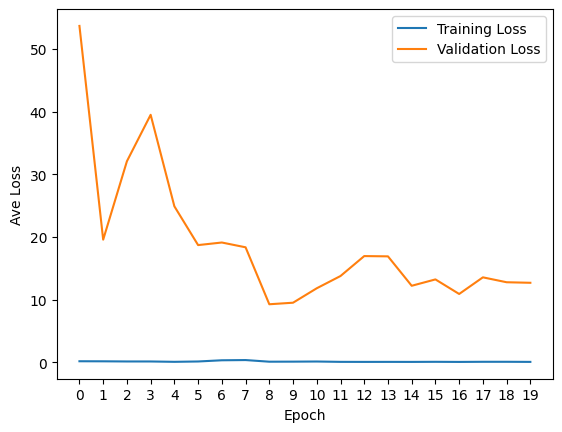

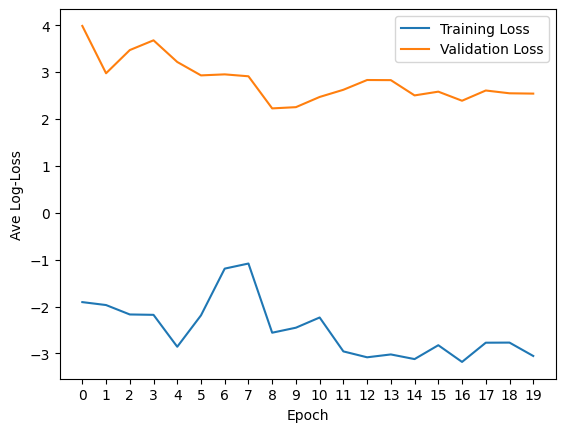

In [12]:
# plot the training loss for each epoch

plt.plot(np.vstack((np.mean(train_loss_buf, axis=1), np.mean(val_loss_buf, axis=1))).T)
# set the x axis tick labels to be the epoch numbers
plt.xlabel('Epoch')
plt.ylabel('Ave Loss')
plt.xticks(np.arange(0, epochs, step=1))

# add a legend
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


plt.clf()
plt.plot(np.log(np.vstack((np.mean(train_loss_buf, axis=1), np.mean(val_loss_buf, axis=1))).T))
plt.xlabel('Epoch')
plt.ylabel('Ave Log-Loss')
plt.xticks(np.arange(0, epochs, step=1))


# add a legend
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()





In [ ]:
# Now lets connect the current model to RLBench to step through the task and evaluate how often it receives a reward in the task.
from rlbench.action_modes.action_mode import MoveArmThenGripper
from rlbench.action_modes.arm_action_modes import EndEffectorPoseViaPlanning
from rlbench.action_modes.gripper_action_modes import Discrete
from rlbench.environment import Environment
from rlbench.observation_config import ObservationConfig
from rlbench.tasks import FS10_V1, ReachTarget, PickUpCup

In [ ]:
from transformers import FlavaProcessor, FlavaModel
import numpy as np
import torch

class SlowAgent(object):
    """
    Agent that uses task description and observation to infer FLAVA autoencoder embeddings and then 
    predict the next action with the provided decoder autoregressively.
    
    """

    def __init__(self, decoder_model):
        self.action_shape = (8,)        
        self.encoder_emb = np.empty((1,0,768),dtype=np.float32)
        
        # begin with the sos token
        sos = torch.from_numpy(np.zeros((1,1,self.action_shape[0]), dtype=np.float32)).cuda()
        sos[0,0,0::2] = -1 # even values are -1
        self.decoder_actions = sos
        # Retrieve the Flava model and processor
        self.flava_model = FlavaModel.from_pretrained('facebook/flava-full')
        self.flava_processor = FlavaProcessor.from_pretrained('facebook/flava-full')
        self.action_decoder_model = decoder_model


    def get_flava_embeddings(self, img, instruction):
        # Convert the observation and instruction into a batch of inputs for the Flava model
        inputs = self.flava_processor(img, instruction, return_tensors="pt", padding="max_length", max_length=197, return_codebook_pixels=False, return_image_mask=False)
        # Pass the inputs through the Flava model
        outputs = self.flava_model(**inputs)
        # Retrieve the multimodal embeddings from the Flava model outputs
        multimodal_embeddings = outputs.multimodal_embeddings.detach().numpy()
        return multimodal_embeddings
    
    def act(self, img, instruction):        
        # Here we are submitting on image and one instruction at a time in an autoregressive fashion
        encoder_emb = self.get_flava_embeddings(img, instruction)
        # Apply mean pooling to the encoder embeddings to get a single embedding for the observation
        #mean_pool_emb = encoder_emb.reshape(1,encoder_emb.shape[0],encoder_emb.shape[1])
        # Concatenate the mean pooled embedding to the encoder embeddings
        self.encoder_emb = np.concatenate((self.encoder_emb, encoder_emb), axis=1)

        self.action_decoder_model.eval()  # turn on evaluation mode    
        memory_emb = torch.from_numpy(self.encoder_emb).cuda()
        with torch.no_grad():
            # Get the decoder action from the action decoder model
            decoder_action = self.action_decoder_model(actions=self.decoder_actions, memory=memory_emb) 
            # Normalize the quaternion values
            decoder_action[0,0,3:7] = decoder_action[0,0,3:7] / torch.norm(decoder_action[0,0,3:7])           
            # Add the action to the decoder actions
            self.decoder_actions = torch.cat((self.decoder_actions, decoder_action), dim=1)
        return decoder_action.detach().cpu().numpy().squeeze()


In [ ]:
obs_config = ObservationConfig()
obs_config.set_all(True)

env = Environment(
    action_mode=MoveArmThenGripper(
        arm_action_mode=EndEffectorPoseViaPlanning(absolute_mode=True), gripper_action_mode=Discrete()),
    obs_config=ObservationConfig(),
    headless=False)
env.launch()

In [ ]:
# Instantiate the agent
model.test_mode = True
agent = SlowAgent(decoder_model=model)
# Get the task
task = env.get_task(ReachTarget)
# Reset the task
descriptions, obs = task.reset()
instruction = descriptions[1]
print(instruction)
plt.imshow(obs.front_rgb)
plt.show()


In [ ]:
# Take steps in the task and print the reward
for i in range(1):
    action = agent.act(obs.front_rgb, instruction)
    print(f'action: {action}')
    if action[0] > 0:
        obs, reward, terminate = task.step(action)
        print(f'Step: {i} Reward: {reward}')
    else:
        print("No action taken")
        break
    plt.imshow(obs.front_rgb)

In [ ]:
env.shutdown()